# Aima lib minimize

In [10]:
"""Provides some utilities widely used by other modules"""

import bisect
import collections
import collections.abc
import operator
import os.path
import random
import math
import functools
from itertools import chain, combinations


# ______________________________________________________________________________
# Functions on Sequences and Iterables


def sequence(iterable):
    """Coerce iterable to sequence, if it is not already one."""
    return (iterable if isinstance(iterable, collections.abc.Sequence)
            else tuple(iterable))


def removeall(item, seq):
    """Return a copy of seq (or string) with all occurences of item removed."""
    if isinstance(seq, str):
        return seq.replace(item, '')
    else:
        return [x for x in seq if x != item]


def unique(seq):  # TODO: replace with set
    """Remove duplicate elements from seq. Assumes hashable elements."""
    return list(set(seq))


def count(seq):
    """Count the number of items in sequence that are interpreted as true."""
    return sum(bool(x) for x in seq)


def product(numbers):
    """Return the product of the numbers, e.g. product([2, 3, 10]) == 60"""
    result = 1
    for x in numbers:
        result *= x
    return result


def first(iterable, default=None):
    """Return the first element of an iterable or the next element of a generator; or default."""
    try:
        return iterable[0]
    except IndexError:
        return default
    except TypeError:
        return next(iterable, default)


def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)


def mode(data):
    """Return the most common data item. If there are ties, return any one of them."""
    [(item, count)] = collections.Counter(data).most_common(1)
    return item


def powerset(iterable):
    """powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"""
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))[1:]


# ______________________________________________________________________________
# argmin and argmax


identity = lambda x: x

argmin = min
argmax = max


def argmin_random_tie(seq, key=identity):
    """Return a minimum element of seq; break ties at random."""
    return argmin(shuffled(seq), key=key)


def argmax_random_tie(seq, key=identity):
    """Return an element with highest fn(seq[i]) score; break ties at random."""
    return argmax(shuffled(seq), key=key)


def shuffled(iterable):
    """Randomly shuffle a copy of iterable."""
    items = list(iterable)
    random.shuffle(items)
    return items


# ______________________________________________________________________________
# Statistical and mathematical functions


def histogram(values, mode=0, bin_function=None):
    """Return a list of (value, count) pairs, summarizing the input values.
    Sorted by increasing value, or if mode=1, by decreasing count.
    If bin_function is given, map it over values first."""
    if bin_function:
        values = map(bin_function, values)

    bins = {}
    for val in values:
        bins[val] = bins.get(val, 0) + 1

    if mode:
        return sorted(list(bins.items()), key=lambda x: (x[1], x[0]),
                      reverse=True)
    else:
        return sorted(bins.items())


def dotproduct(X, Y):
    """Return the sum of the element-wise product of vectors X and Y."""
    return sum(x * y for x, y in zip(X, Y))


def element_wise_product(X, Y):
    """Return vector as an element-wise product of vectors X and Y"""
    assert len(X) == len(Y)
    return [x * y for x, y in zip(X, Y)]


def matrix_multiplication(X_M, *Y_M):
    """Return a matrix as a matrix-multiplication of X_M and arbitary number of matrices *Y_M"""

    def _mat_mult(X_M, Y_M):
        """Return a matrix as a matrix-multiplication of two matrices X_M and Y_M
        >>> matrix_multiplication([[1, 2, 3],
                                   [2, 3, 4]],
                                   [[3, 4],
                                    [1, 2],
                                    [1, 0]])
        [[8, 8],[13, 14]]
        """
        assert len(X_M[0]) == len(Y_M)

        result = [[0 for i in range(len(Y_M[0]))] for j in range(len(X_M))]
        for i in range(len(X_M)):
            for j in range(len(Y_M[0])):
                for k in range(len(Y_M)):
                    result[i][j] += X_M[i][k] * Y_M[k][j]
        return result

    result = X_M
    for Y in Y_M:
        result = _mat_mult(result, Y)

    return result


def vector_to_diagonal(v):
    """Converts a vector to a diagonal matrix with vector elements
    as the diagonal elements of the matrix"""
    diag_matrix = [[0 for i in range(len(v))] for j in range(len(v))]
    for i in range(len(v)):
        diag_matrix[i][i] = v[i]

    return diag_matrix


def vector_add(a, b):
    """Component-wise addition of two vectors."""
    return tuple(map(operator.add, a, b))


def scalar_vector_product(X, Y):
    """Return vector as a product of a scalar and a vector"""
    return [X * y for y in Y]


def scalar_matrix_product(X, Y):
    """Return matrix as a product of a scalar and a matrix"""
    return [scalar_vector_product(X, y) for y in Y]


def inverse_matrix(X):
    """Inverse a given square matrix of size 2x2"""
    assert len(X) == 2
    assert len(X[0]) == 2
    det = X[0][0] * X[1][1] - X[0][1] * X[1][0]
    assert det != 0
    inv_mat = scalar_matrix_product(1.0/det, [[X[1][1], -X[0][1]], [-X[1][0], X[0][0]]])

    return inv_mat


def probability(p):
    """Return true with probability p."""
    return p > random.uniform(0.0, 1.0)


def weighted_sample_with_replacement(n, seq, weights):
    """Pick n samples from seq at random, with replacement, with the
    probability of each element in proportion to its corresponding
    weight."""
    sample = weighted_sampler(seq, weights)

    return [sample() for _ in range(n)]


def weighted_sampler(seq, weights):
    """Return a random-sample function that picks from seq weighted by weights."""
    totals = []
    for w in weights:
        totals.append(w + totals[-1] if totals else w)

    return lambda: seq[bisect.bisect(totals, random.uniform(0, totals[-1]))]


def rounder(numbers, d=4):
    """Round a single number, or sequence of numbers, to d decimal places."""
    if isinstance(numbers, (int, float)):
        return round(numbers, d)
    else:
        constructor = type(numbers)     # Can be list, set, tuple, etc.
        return constructor(rounder(n, d) for n in numbers)


def num_or_str(x):
    """The argument is a string; convert to a number if
       possible, or strip it."""
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return str(x).strip()


def normalize(dist):
    """Multiply each number by a constant such that the sum is 1.0"""
    if isinstance(dist, dict):
        total = sum(dist.values())
        for key in dist:
            dist[key] = dist[key] / total
            assert 0 <= dist[key] <= 1, "Probabilities must be between 0 and 1."
        return dist
    total = sum(dist)
    return [(n / total) for n in dist]


def norm(X, n=2):
    """Return the n-norm of vector X"""
    return sum([x**n for x in X])**(1/n)


def clip(x, lowest, highest):
    """Return x clipped to the range [lowest..highest]."""
    return max(lowest, min(x, highest))


def sigmoid_derivative(value):
    return value * (1 - value)


def sigmoid(x):
    """Return activation value of x with sigmoid function"""
    return 1/(1 + math.exp(-x))


def step(x):
    """Return activation value of x with sign function"""
    return 1 if x >= 0 else 0


def gaussian(mean, st_dev, x):
    """Given the mean and standard deviation of a distribution, it returns the probability of x."""
    return 1/(math.sqrt(2*math.pi)*st_dev)*math.e**(-0.5*(float(x-mean)/st_dev)**2)


try:  # math.isclose was added in Python 3.5; but we might be in 3.4
    from math import isclose
except ImportError:
    def isclose(a, b, rel_tol=1e-09, abs_tol=0.0):
        """Return true if numbers a and b are close to each other."""
        return abs(a - b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)


def weighted_choice(choices):
    """A weighted version of random.choice"""
    # NOTE: Shoule be replaced by random.choices if we port to Python 3.6

    total = sum(w for _, w in choices)
    r = random.uniform(0, total)
    upto = 0
    for c, w in choices:
        if upto + w >= r:
            return c, w
        upto += w


# ______________________________________________________________________________
# Grid Functions


orientations = EAST, NORTH, WEST, SOUTH = [(1, 0), (0, 1), (-1, 0), (0, -1)]
turns = LEFT, RIGHT = (+1, -1)


def turn_heading(heading, inc, headings=orientations):
    return headings[(headings.index(heading) + inc) % len(headings)]


def turn_right(heading):
    return turn_heading(heading, RIGHT)


def turn_left(heading):
    return turn_heading(heading, LEFT)


def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return math.hypot((xA - xB), (yA - yB))


def distance_squared(a, b):
    """The square of the distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return (xA - xB)**2 + (yA - yB)**2


def vector_clip(vector, lowest, highest):
    """Return vector, except if any element is less than the corresponding
    value of lowest or more than the corresponding value of highest, clip to
    those values."""
    return type(vector)(map(clip, vector, lowest, highest))


# ______________________________________________________________________________
# Misc Functions


def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn


def name(obj):
    """Try to find some reasonable name for the object."""
    return (getattr(obj, 'name', 0) or getattr(obj, '__name__', 0) or
            getattr(getattr(obj, '__class__', 0), '__name__', 0) or
            str(obj))


def isnumber(x):
    """Is x a number?"""
    return hasattr(x, '__int__')


def issequence(x):
    """Is x a sequence?"""
    return isinstance(x, collections.abc.Sequence)


def print_table(table, header=None, sep='   ', numfmt='{}'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '{:.2f}'.
    (If you want different formats in different columns,
    don't use print_table.) sep is the separator between columns."""
    justs = ['rjust' if isnumber(x) else 'ljust' for x in table[0]]

    if header:
        table.insert(0, header)

    table = [[numfmt.format(x) if isnumber(x) else x for x in row]
             for row in table]

    sizes = list(
            map(lambda seq: max(map(len, seq)),
                list(zip(*[map(str, row) for row in table]))))

    for row in table:
        print(sep.join(getattr(
            str(x), j)(size) for (j, size, x) in zip(justs, sizes, row)))


def open_data(name, mode='r'):
    aima_root = os.path.dirname(__file__)
    aima_file = os.path.join(aima_root, *['aima-data', name])

    return open(aima_file)


def failure_test(algorithm, tests):
    """Grades the given algorithm based on how many tests it passes.
    Most algorithms have arbitary output on correct execution, which is difficult
    to check for correctness. On the other hand, a lot of algorithms output something
    particular on fail (for example, False, or None).
    tests is a list with each element in the form: (values, failure_output)."""
    from statistics import mean
    return mean(int(algorithm(x) != y) for x, y in tests)


# ______________________________________________________________________________
# Expressions

# See https://docs.python.org/3/reference/expressions.html#operator-precedence
# See https://docs.python.org/3/reference/datamodel.html#special-method-names

class Expr(object):
    """A mathematical expression with an operator and 0 or more arguments.
    op is a str like '+' or 'sin'; args are Expressions.
    Expr('x') or Symbol('x') creates a symbol (a nullary Expr).
    Expr('-', x) creates a unary; Expr('+', x, 1) creates a binary."""

    def __init__(self, op, *args):
        self.op = str(op)
        self.args = args

    # Operator overloads
    def __neg__(self):
        return Expr('-', self)

    def __pos__(self):
        return Expr('+', self)

    def __invert__(self):
        return Expr('~', self)

    def __add__(self, rhs):
        return Expr('+', self, rhs)

    def __sub__(self, rhs):
        return Expr('-', self, rhs)

    def __mul__(self, rhs):
        return Expr('*', self, rhs)

    def __pow__(self, rhs):
        return Expr('**', self, rhs)

    def __mod__(self, rhs):
        return Expr('%', self, rhs)

    def __and__(self, rhs):
        return Expr('&', self, rhs)

    def __xor__(self, rhs):
        return Expr('^', self, rhs)

    def __rshift__(self, rhs):
        return Expr('>>', self, rhs)

    def __lshift__(self, rhs):
        return Expr('<<', self, rhs)

    def __truediv__(self, rhs):
        return Expr('/', self, rhs)

    def __floordiv__(self, rhs):
        return Expr('//', self, rhs)

    def __matmul__(self, rhs):
        return Expr('@', self, rhs)

    def __or__(self, rhs):
        """Allow both P | Q, and P |'==>'| Q."""
        if isinstance(rhs, Expression):
            return Expr('|', self, rhs)
        else:
            return PartialExpr(rhs, self)

    # Reverse operator overloads
    def __radd__(self, lhs):
        return Expr('+', lhs, self)

    def __rsub__(self, lhs):
        return Expr('-', lhs, self)

    def __rmul__(self, lhs):
        return Expr('*', lhs, self)

    def __rdiv__(self, lhs):
        return Expr('/', lhs, self)

    def __rpow__(self, lhs):
        return Expr('**', lhs, self)

    def __rmod__(self, lhs):
        return Expr('%', lhs, self)

    def __rand__(self, lhs):
        return Expr('&', lhs, self)

    def __rxor__(self, lhs):
        return Expr('^', lhs, self)

    def __ror__(self, lhs):
        return Expr('|', lhs, self)

    def __rrshift__(self, lhs):
        return Expr('>>', lhs, self)

    def __rlshift__(self, lhs):
        return Expr('<<', lhs, self)

    def __rtruediv__(self, lhs):
        return Expr('/', lhs, self)

    def __rfloordiv__(self, lhs):
        return Expr('//', lhs, self)

    def __rmatmul__(self, lhs):
        return Expr('@', lhs, self)

    def __call__(self, *args):
        "Call: if 'f' is a Symbol, then f(0) == Expr('f', 0)."
        if self.args:
            raise ValueError('can only do a call for a Symbol, not an Expr')
        else:
            return Expr(self.op, *args)

    # Equality and repr
    def __eq__(self, other):
        "'x == y' evaluates to True or False; does not build an Expr."
        return (isinstance(other, Expr)
                and self.op == other.op
                and self.args == other.args)

    def __hash__(self): return hash(self.op) ^ hash(self.args)

    def __repr__(self):
        op = self.op
        args = [str(arg) for arg in self.args]
        if op.isidentifier():       # f(x) or f(x, y)
            return '{}({})'.format(op, ', '.join(args)) if args else op
        elif len(args) == 1:        # -x or -(x + 1)
            return op + args[0]
        else:                       # (x - y)
            opp = (' ' + op + ' ')
            return '(' + opp.join(args) + ')'

# An 'Expression' is either an Expr or a Number.
# Symbol is not an explicit type; it is any Expr with 0 args.


Number = (int, float, complex)
Expression = (Expr, Number)


def Symbol(name):
    """A Symbol is just an Expr with no args."""
    return Expr(name)


def symbols(names):
    """Return a tuple of Symbols; names is a comma/whitespace delimited str."""
    return tuple(Symbol(name) for name in names.replace(',', ' ').split())


def subexpressions(x):
    """Yield the subexpressions of an Expression (including x itself)."""
    yield x
    if isinstance(x, Expr):
        for arg in x.args:
            yield from subexpressions(arg)


def arity(expression):
    """The number of sub-expressions in this expression."""
    if isinstance(expression, Expr):
        return len(expression.args)
    else:  # expression is a number
        return 0

# For operators that are not defined in Python, we allow new InfixOps:


class PartialExpr:
    """Given 'P |'==>'| Q, first form PartialExpr('==>', P), then combine with Q."""
    def __init__(self, op, lhs):
        self.op, self.lhs = op, lhs

    def __or__(self, rhs):
        return Expr(self.op, self.lhs, rhs)

    def __repr__(self):
        return "PartialExpr('{}', {})".format(self.op, self.lhs)


def expr(x):
    """Shortcut to create an Expression. x is a str in which:
    - identifiers are automatically defined as Symbols.
    - ==> is treated as an infix |'==>'|, as are <== and <=>.
    If x is already an Expression, it is returned unchanged. Example:
    >>> expr('P & Q ==> Q')
    ((P & Q) ==> Q)
    """
    if isinstance(x, str):
        return eval(expr_handle_infix_ops(x), defaultkeydict(Symbol))
    else:
        return x


infix_ops = '==> <== <=>'.split()


def expr_handle_infix_ops(x):
    """Given a str, return a new str with ==> replaced by |'==>'|, etc.
    >>> expr_handle_infix_ops('P ==> Q')
    "P |'==>'| Q"
    """
    for op in infix_ops:
        x = x.replace(op, '|' + repr(op) + '|')
    return x


class defaultkeydict(collections.defaultdict):
    """Like defaultdict, but the default_factory is a function of the key.
    >>> d = defaultkeydict(len); d['four']
    4
    """
    def __missing__(self, key):
        self[key] = result = self.default_factory(key)
        return result


class hashabledict(dict):
    """Allows hashing by representing a dictionary as tuple of key:value pairs
       May cause problems as the hash value may change during runtime
    """
    def __tuplify__(self):
        return tuple(sorted(self.items()))

    def __hash__(self):
        return hash(self.__tuplify__())

    def __lt__(self, odict):
        assert isinstance(odict, hashabledict)
        return self.__tuplify__() < odict.__tuplify__()

    def __gt__(self, odict):
        assert isinstance(odict, hashabledict)
        return self.__tuplify__() > odict.__tuplify__()

    def __le__(self, odict):
        assert isinstance(odict, hashabledict)
        return self.__tuplify__() <= odict.__tuplify__()

    def __ge__(self, odict):
        assert isinstance(odict, hashabledict)
        return self.__tuplify__() >= odict.__tuplify__()


# ______________________________________________________________________________
# Queues: Stack, FIFOQueue, PriorityQueue

# TODO: queue.PriorityQueue
# TODO: Priority queues may not belong here -- see treatment in search.py


class Queue:

    """Queue is an abstract class/interface. There are three types:
        Stack(): A Last In First Out Queue.
        FIFOQueue(): A First In First Out Queue.
        PriorityQueue(order, f): Queue in sorted order (default min-first).
    Each type supports the following methods and functions:
        q.append(item)  -- add an item to the queue
        q.extend(items) -- equivalent to: for item in items: q.append(item)
        q.pop()         -- return the top item from the queue
        len(q)          -- number of items in q (also q.__len())
        item in q       -- does q contain item?
    Note that isinstance(Stack(), Queue) is false, because we implement stacks
    as lists.  If Python ever gets interfaces, Queue will be an interface."""

    def __init__(self):
        raise NotImplementedError

    def extend(self, items):
        for item in items:
            self.append(item)


def Stack():
    """Return an empty list, suitable as a Last-In-First-Out Queue."""
    return []


class FIFOQueue(Queue):

    """A First-In-First-Out Queue."""

    def __init__(self, maxlen=None, items=[]):
        self.queue = collections.deque(items, maxlen)

    def append(self, item):
        if not self.queue.maxlen or len(self.queue) < self.queue.maxlen:
            self.queue.append(item)
        else:
            raise Exception('FIFOQueue is full')

    def extend(self, items):
        if not self.queue.maxlen or len(self.queue) + len(items) <= self.queue.maxlen:
            self.queue.extend(items)
        else:
            raise Exception('FIFOQueue max length exceeded')

    def pop(self):
        if len(self.queue) > 0:
            return self.queue.popleft()
        else:
            raise Exception('FIFOQueue is empty')

    def __len__(self):
        return len(self.queue)

    def __contains__(self, item):
        return item in self.queue


class PriorityQueue(Queue):

    """A queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first. If order is min, the item with minimum f(x) is
    returned first; if order is max, then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order=min, f=lambda x: x):
        self.A = []
        self.order = order
        self.f = f

    def append(self, item):
        bisect.insort(self.A, (self.f(item), item))

    def __len__(self):
        return len(self.A)

    def pop(self):
        if self.order == min:
            return self.A.pop(0)[1]
        else:
            return self.A.pop()[1]

    def __contains__(self, item):
        return any(item == pair[1] for pair in self.A)

    def __getitem__(self, key):
        for _, item in self.A:
            if item == key:
                return item

    def __delitem__(self, key):
        for i, (value, item) in enumerate(self.A):
            if item == key:
                self.A.pop(i)


# ______________________________________________________________________________
# Useful Shorthands


class Bool(int):
    """Just like `bool`, except values display as 'T' and 'F' instead of 'True' and 'False'"""
    __str__ = __repr__ = lambda self: 'T' if self else 'F'


T = Bool(True)
F = Bool(False)


In [11]:
"""Search (Chapters 3-4)

The way to use this code is to subclass Problem to create a class of problems,
then create problem instances and solve them with calls to the various search
functions."""
"""
from .utils import (
    is_in, argmin, argmax, argmax_random_tie, probability, weighted_sampler,
    memoize, print_table, open_data, Stack, FIFOQueue, PriorityQueue, name,
    distance, vector_add
)
"""
from collections import defaultdict
import math
import random
import sys
import bisect
from operator import itemgetter


infinity = float('inf')

# ______________________________________________________________________________


class Problem(object):

    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError
# ______________________________________________________________________________


class Node:

    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next = problem.result(self.state, action)
        return Node(next, self, action,
                    problem.path_cost(self.path_cost, self.state,
                                      action, next))

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        return hash(self.state)

# ______________________________________________________________________________


class SimpleProblemSolvingAgentProgram:

    """Abstract framework for a problem-solving agent. [Figure 3.1]"""

    def __init__(self, initial_state=None):
        """State is an sbstract representation of the state
        of the world, and seq is the list of actions required
        to get to a particular state from the initial state(root)."""
        self.state = initial_state
        self.seq = []

    def __call__(self, percept):
        """[Figure 3.1] Formulate a goal and problem, then
        search for a sequence of actions to solve it."""
        self.state = self.update_state(self.state, percept)
        if not self.seq:
            goal = self.formulate_goal(self.state)
            problem = self.formulate_problem(self.state, goal)
            self.seq = self.search(problem)
            if not self.seq:
                return None
        return self.seq.pop(0)

    def update_state(self, percept):
        raise NotImplementedError

    def formulate_goal(self, state):
        raise NotImplementedError

    def formulate_problem(self, state, goal):
        raise NotImplementedError

    def search(self, problem):
        raise NotImplementedError

# ______________________________________________________________________________
# Uninformed Search algorithms


def tree_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    frontier.append(Node(problem.initial))
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        frontier.extend(node.expand(problem))
    return None


def graph_search(problem, frontier):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    frontier.append(Node(problem.initial))
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
    return None


def breadth_first_tree_search(problem):
    """Search the shallowest nodes in the search tree first."""
    return tree_search(problem, FIFOQueue())


def depth_first_tree_search(problem):
    """Search the deepest nodes in the search tree first."""
    return tree_search(problem, Stack())


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    return graph_search(problem, Stack())


def breadth_first_search(problem):
    """[Figure 3.11]"""
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = FIFOQueue()
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    return child
                frontier.append(child)
    return None


def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    f = memoize(f, 'f')
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = PriorityQueue(min, f)
    frontier.append(node)
    explored = set()
    while frontier:
        node = frontier.pop()
        if problem.goal_test(node.state):
            return node
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
    return None


def uniform_cost_search(problem):
    """[Figure 3.14]"""
    return best_first_graph_search(problem, lambda node: node.path_cost)


def depth_limited_search(problem, limit=50):
    """[Figure 3.17]"""
    def recursive_dls(node, problem, limit):
        if problem.goal_test(node.state):
            return node
        elif limit == 0:
            return 'cutoff'
        else:
            cutoff_occurred = False
            for child in node.expand(problem):
                result = recursive_dls(child, problem, limit - 1)
                if result == 'cutoff':
                    cutoff_occurred = True
                elif result is not None:
                    return result
            return 'cutoff' if cutoff_occurred else None

    # Body of depth_limited_search:
    return recursive_dls(Node(problem.initial), problem, limit)


def iterative_deepening_search(problem):
    """[Figure 3.18]"""
    for depth in range(sys.maxsize):
        result = depth_limited_search(problem, depth)
        if result != 'cutoff':
            return result

# ______________________________________________________________________________
# Bidirectional Search
# Pseudocode from https://webdocs.cs.ualberta.ca/%7Eholte/Publications/MM-AAAI2016.pdf

def bidirectional_search(problem):
    e = problem.find_min_edge()
    gF, gB = {problem.initial : 0}, {problem.goal : 0}
    openF, openB = [problem.initial], [problem.goal]
    closedF, closedB = [], []
    U = infinity


    def extend(U, open_dir, open_other, g_dir, g_other, closed_dir):
        """Extend search in given direction"""
        n = find_key(C, open_dir, g_dir)

        open_dir.remove(n)
        closed_dir.append(n)

        for c in problem.actions(n):
            if c in open_dir or c in closed_dir:
                if g_dir[c] <= problem.path_cost(g_dir[n], n, None, c):
                    continue

                open_dir.remove(c)

            g_dir[c] = problem.path_cost(g_dir[n], n, None, c)
            open_dir.append(c)

            if c in open_other:
                U = min(U, g_dir[c] + g_other[c])

        return U, open_dir, closed_dir, g_dir


    def find_min(open_dir, g):
        """Finds minimum priority, g and f values in open_dir"""
        m, m_f = infinity, infinity
        for n in open_dir:
            f = g[n] + problem.h(n)
            pr = max(f, 2*g[n])
            m = min(m, pr)
            m_f = min(m_f, f)

        return m, m_f, min(g.values())


    def find_key(pr_min, open_dir, g):
        """Finds key in open_dir with value equal to pr_min
        and minimum g value."""
        m = infinity
        state = -1
        for n in open_dir:
            pr = max(g[n] + problem.h(n), 2*g[n])
            if pr == pr_min:
                if g[n] < m:
                    m = g[n]
                    state = n

        return state


    while openF and openB:
        pr_min_f, f_min_f, g_min_f = find_min(openF, gF)
        pr_min_b, f_min_b, g_min_b = find_min(openB, gB)
        C = min(pr_min_f, pr_min_b)

        if U <= max(C, f_min_f, f_min_b, g_min_f + g_min_b + e):
            return U

        if C == pr_min_f:
            # Extend forward
            U, openF, closedF, gF = extend(U, openF, openB, gF, gB, closedF)
        else:
            # Extend backward
            U, openB, closedB, gB = extend(U, openB, openF, gB, gF, closedB)

    return infinity

# ______________________________________________________________________________
# Informed (Heuristic) Search


greedy_best_first_graph_search = best_first_graph_search
# Greedy best-first search is accomplished by specifying f(n) = h(n).


def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    return best_first_graph_search(problem, lambda n: n.path_cost + h(n))

# ______________________________________________________________________________
# A* heuristics

class EightPuzzle():

    def __init__(self):
        self.path = []
        self.final = []

    def checkSolvability(self, state):
        inversion = 0
        for i in range(len(state)):
               for j in range(i,len(state)):
                    if (state[i]>state[j] and state[j]!=0):
                                    inversion += 1
        check = True
        if inversion%2 != 0:
                check = False
        print(check)

    def getPossibleMoves(self,state,heuristic,goal,moves):
        move = {0:[1,3], 1:[0,2,4], 2:[1,5], 3:[0,6,4], 4:[1,3,5,7], 5:[2,4,8], 6:[3,7], 7:[6,8], 8:[7,5]} # create a dictionary of moves
        index = state[0].index(0)
        possible_moves = []
        for i in range(len(move[index])):
                conf = list(state[0][:])
                a = conf[index]
                b = conf[move[index][i]]
                conf[move[index][i]] = a
                conf[index] = b
                possible_moves.append(conf)
        scores = []
        for i in possible_moves:
                scores.append(heuristic(i,goal))
        scores = [x+moves for x in scores]
        allowed_state = []
        for i in range(len(possible_moves)):
                node = []
                node.append(possible_moves[i])
                node.append(scores[i])
                node.append(state[0])
                allowed_state.append(node)
        return allowed_state


    def create_path(self,goal,initial):
        node = goal[0]
        self.final.append(goal[0])
        if goal[2] == initial:
                return reversed(self.final)
        else:
                parent = goal[2]
                for i in self.path:
                        if i[0] == parent:
                                parent = i
                self.create_path(parent,initial)

    def show_path(self,initial):
        move = []
        for i in range(0,len(self.path)):
                move.append(''.join(str(x) for x in self.path[i][0]))

        print("Number of explored nodes by the following heuristic are: ", len(set(move)))
        print(initial)
        for i in reversed(self.final):
            print(i)

        del self.path[:]
        del self.final[:]
        return

    def solve(self,initial,goal,heuristic):
        root = [initial,heuristic(initial,goal),'']
        nodes = [] # nodes is a priority Queue based on the state score
        nodes.append(root)
        moves = 0
        while len(nodes) != 0:
                node = nodes[0]
                del nodes[0]
                self.path.append(node)
                if node[0] == goal:
                        soln = self.create_path(self.path[-1],initial )
                        self.show_path(initial)
                        return
                moves +=1
                opened_nodes = self.getPossibleMoves(node,heuristic,goal,moves)
                nodes = sorted(opened_nodes+nodes, key=itemgetter(1))


# ______________________________________________________________________________
# Other search algorithms


def recursive_best_first_search(problem, h=None):
    """[Figure 3.26]"""
    h = memoize(h or problem.h, 'h')

    def RBFS(problem, node, flimit):
        if problem.goal_test(node.state):
            return node, 0   # (The second value is immaterial)
        successors = node.expand(problem)
        if len(successors) == 0:
            return None, infinity
        for s in successors:
            s.f = max(s.path_cost + h(s), node.f)
        while True:
            # Order by lowest f value
            successors.sort(key=lambda x: x.f)
            best = successors[0]
            if best.f > flimit:
                return None, best.f
            if len(successors) > 1:
                alternative = successors[1].f
            else:
                alternative = infinity
            result, best.f = RBFS(problem, best, min(flimit, alternative))
            if result is not None:
                return result, best.f

    node = Node(problem.initial)
    node.f = h(node)
    result, bestf = RBFS(problem, node, infinity)
    return result


def hill_climbing(problem):
    """From the initial node, keep choosing the neighbor with highest value,
    stopping when no neighbor is better. [Figure 4.2]"""
    current = Node(problem.initial)
    while True:
        neighbors = current.expand(problem)
        if not neighbors:
            break
        neighbor = argmax_random_tie(neighbors,
                                     key=lambda node: problem.value(node.state))
        if problem.value(neighbor.state) <= problem.value(current.state):
            break
        current = neighbor
    return current.state


def exp_schedule(k=20, lam=0.005, limit=100):
    """One possible schedule function for simulated annealing"""
    return lambda t: (k * math.exp(-lam * t) if t < limit else 0)


def simulated_annealing(problem, schedule=exp_schedule()):
    """[Figure 4.5] CAUTION: This differs from the pseudocode as it
    returns a state instead of a Node."""
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        T = schedule(t)
        if T == 0:
            return current.state
        neighbors = current.expand(problem)
        if not neighbors:
            return current.state
        next = random.choice(neighbors)
        delta_e = problem.value(next.state) - problem.value(current.state)
        if delta_e > 0 or probability(math.exp(delta_e / T)):
            current = next

def simulated_annealing_full(problem, schedule=exp_schedule()):
    """ This version returns all the states encountered in reaching
    the goal state."""
    states = []
    current = Node(problem.initial)
    for t in range(sys.maxsize):
        states.append(current.state)
        T = schedule(t)
        if T == 0:
            return states
        neighbors = current.expand(problem)
        if not neighbors:
            return current.state
        next = random.choice(neighbors)
        delta_e = problem.value(next.state) - problem.value(current.state)
        if delta_e > 0 or probability(math.exp(delta_e / T)):
            current = next

def and_or_graph_search(problem):
    """[Figure 4.11]Used when the environment is nondeterministic and completely observable.
    Contains OR nodes where the agent is free to choose any action.
    After every action there is an AND node which contains all possible states
    the agent may reach due to stochastic nature of environment.
    The agent must be able to handle all possible states of the AND node (as it
    may end up in any of them).
    Returns a conditional plan to reach goal state,
    or failure if the former is not possible."""

    # functions used by and_or_search
    def or_search(state, problem, path):
        """returns a plan as a list of actions"""
        if problem.goal_test(state):
            return []
        if state in path:
            return None
        for action in problem.actions(state):
            plan = and_search(problem.result(state, action),
                              problem, path + [state, ])
            if plan is not None:
                return [action, plan]

    def and_search(states, problem, path):
        """Returns plan in form of dictionary where we take action plan[s] if we reach state s."""
        plan = {}
        for s in states:
            plan[s] = or_search(s, problem, path)
            if plan[s] is None:
                return None
        return plan

    # body of and or search
    return or_search(problem.initial, problem, [])

# Pre-defined actions for PeakFindingProblem
directions4 = { 'W':(-1, 0), 'N':(0, 1), 'E':(1, 0), 'S':(0, -1) }
directions8 = dict(directions4)
directions8.update({'NW':(-1, 1), 'NE':(1, 1), 'SE':(1, -1), 'SW':(-1, -1) })

class PeakFindingProblem(Problem):
    """Problem of finding the highest peak in a limited grid"""

    def __init__(self, initial, grid, defined_actions=directions4):
        """The grid is a 2 dimensional array/list whose state is specified by tuple of indices"""
        Problem.__init__(self, initial)
        self.grid = grid
        self.defined_actions = defined_actions
        self.n = len(grid)
        assert self.n > 0
        self.m = len(grid[0])
        assert self.m > 0

    def actions(self, state):
        """Returns the list of actions which are allowed to be taken from the given state"""
        allowed_actions = []
        for action in self.defined_actions:
            next_state = vector_add(state, self.defined_actions[action])
            if next_state[0] >= 0 and next_state[1] >= 0 and next_state[0] <= self.n - 1 and next_state[1] <= self.m - 1:
                allowed_actions.append(action)

        return allowed_actions

    def result(self, state, action):
        """Moves in the direction specified by action"""
        return vector_add(state, self.defined_actions[action])

    def value(self, state):
        """Value of a state is the value it is the index to"""
        x, y = state
        assert 0 <= x < self.n
        assert 0 <= y < self.m
        return self.grid[x][y]


class OnlineDFSAgent:

    """[Figure 4.21] The abstract class for an OnlineDFSAgent. Override
    update_state method to convert percept to state. While initializing
    the subclass a problem needs to be provided which is an instance of
    a subclass of the Problem class."""

    def __init__(self, problem):
        self.problem = problem
        self.s = None
        self.a = None
        self.untried = defaultdict(list)
        self.unbacktracked = defaultdict(list)
        self.result = {}

    def __call__(self, percept):
        s1 = self.update_state(percept)
        if self.problem.goal_test(s1):
            self.a = None
        else:
            if s1 not in self.untried.keys():
                self.untried[s1] = self.problem.actions(s1)
            if self.s is not None:
                if s1 != self.result[(self.s, self.a)]:
                    self.result[(self.s, self.a)] = s1
                    self.unbacktracked[s1].insert(0, self.s)
            if len(self.untried[s1]) == 0:
                if len(self.unbacktracked[s1]) == 0:
                    self.a = None
                else:
                    # else a <- an action b such that result[s', b] = POP(unbacktracked[s'])
                    unbacktracked_pop = self.unbacktracked[s1].pop(0)
                    for (s, b) in self.result.keys():
                        if self.result[(s, b)] == unbacktracked_pop:
                            self.a = b
                            break
            else:
                self.a = self.untried[s1].pop(0)
        self.s = s1
        return self.a

    def update_state(self, percept):
        """To be overridden in most cases. The default case
        assumes the percept to be of type state."""
        return percept

# ______________________________________________________________________________


class OnlineSearchProblem(Problem):
    """
    A problem which is solved by an agent executing
    actions, rather than by just computation.
    Carried in a deterministic and a fully observable environment."""

    def __init__(self, initial, goal, graph):
        self.initial = initial
        self.goal = goal
        self.graph = graph

    def actions(self, state):
        return self.graph.dict[state].keys()

    def output(self, state, action):
        return self.graph.dict[state][action]

    def h(self, state):
        """Returns least possible cost to reach a goal for the given state."""
        return self.graph.least_costs[state]

    def c(self, s, a, s1):
        """Returns a cost estimate for an agent to move from state 's' to state 's1'."""
        return 1

    def update_state(self, percept):
        raise NotImplementedError

    def goal_test(self, state):
        if state == self.goal:
            return True
        return False


class LRTAStarAgent:

    """ [Figure 4.24]
    Abstract class for LRTA*-Agent. A problem needs to be
    provided which is an instance of a subclass of Problem Class.

    Takes a OnlineSearchProblem [Figure 4.23] as a problem.
    """

    def __init__(self, problem):
        self.problem = problem
        # self.result = {}      # no need as we are using problem.result
        self.H = {}
        self.s = None
        self.a = None

    def __call__(self, s1):     # as of now s1 is a state rather than a percept
        if self.problem.goal_test(s1):
            self.a = None
            return self.a
        else:
            if s1 not in self.H:
                self.H[s1] = self.problem.h(s1)
            if self.s is not None:
                # self.result[(self.s, self.a)] = s1    # no need as we are using problem.output

                # minimum cost for action b in problem.actions(s)
                self.H[self.s] = min(self.LRTA_cost(self.s, b, self.problem.output(self.s, b),
                                     self.H) for b in self.problem.actions(self.s))

            # an action b in problem.actions(s1) that minimizes costs
            self.a = argmin(self.problem.actions(s1),
                            key=lambda b: self.LRTA_cost(s1, b, self.problem.output(s1, b), self.H))

            self.s = s1
            return self.a

    def LRTA_cost(self, s, a, s1, H):
        """Returns cost to move from state 's' to state 's1' plus
        estimated cost to get to goal from s1."""
        print(s, a, s1)
        if s1 is None:
            return self.problem.h(s)
        else:
            # sometimes we need to get H[s1] which we haven't yet added to H
            # to replace this try, except: we can initialize H with values from problem.h
            try:
                return self.problem.c(s, a, s1) + self.H[s1]
            except:
                return self.problem.c(s, a, s1) + self.problem.h(s1)

# ______________________________________________________________________________
# Genetic Algorithm


def genetic_search(problem, fitness_fn, ngen=1000, pmut=0.1, n=20):
    """Call genetic_algorithm on the appropriate parts of a problem.
    This requires the problem to have states that can mate and mutate,
    plus a value method that scores states."""

    # NOTE: This is not tested and might not work.
    # TODO: Use this function to make Problems work with genetic_algorithm.

    s = problem.initial_state
    states = [problem.result(s, a) for a in problem.actions(s)]
    random.shuffle(states)
    return genetic_algorithm(states[:n], problem.value, ngen, pmut)


def genetic_algorithm(population, fitness_fn, gene_pool=[0, 1], f_thres=None, ngen=1000, pmut=0.1):
    """[Figure 4.8]"""
    for i in range(ngen):
        population = [mutate(recombine(*select(2, population, fitness_fn)), gene_pool, pmut)
                      for i in range(len(population))]

        fittest_individual = fitness_threshold(fitness_fn, f_thres, population)
        if fittest_individual:
            return fittest_individual


    return argmax(population, key=fitness_fn)


def fitness_threshold(fitness_fn, f_thres, population):
    if not f_thres:
        return None

    fittest_individual = argmax(population, key=fitness_fn)
    if fitness_fn(fittest_individual) >= f_thres:
        return fittest_individual

    return None



def init_population(pop_number, gene_pool, state_length):
    """Initializes population for genetic algorithm
    pop_number  :  Number of individuals in population
    gene_pool   :  List of possible values for individuals
    state_length:  The length of each individual"""
    g = len(gene_pool)
    population = []
    for i in range(pop_number):
        new_individual = [gene_pool[random.randrange(0, g)] for j in range(state_length)]
        population.append(new_individual)

    return population


def select(r, population, fitness_fn):
    fitnesses = map(fitness_fn, population)
    sampler = weighted_sampler(population, fitnesses)
    return [sampler() for i in range(r)]


def recombine(x, y):
    n = len(x)
    c = random.randrange(0, n)
    return x[:c] + y[c:]


def mutate(x, gene_pool, pmut):
    if random.uniform(0, 1) >= pmut:
        return x

    n = len(x)
    g = len(gene_pool)
    c = random.randrange(0, n)
    r = random.randrange(0, g)

    new_gene = gene_pool[r]
    return x[:c] + [new_gene] + x[c+1:]

# _____________________________________________________________________________
# The remainder of this file implements examples for the search algorithms.

# ______________________________________________________________________________
# Graphs and Graph Problems


class Graph:

    """A graph connects nodes (verticies) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, dict=None, directed=True):
        self.dict = dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.dict.keys()):
            for (b, dist) in self.dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        return list(self.dict.keys())


def UndirectedGraph(dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(dict=dict, directed=False)


def RandomGraph(nodes=list(range(10)), min_links=2, width=400, height=300,
                curvature=lambda: random.uniform(1.1, 1.5)):
    """Construct a random graph, with the specified nodes, and random links.
    The nodes are laid out randomly on a (width x height) rectangle.
    Then each node is connected to the min_links nearest neighbors.
    Because inverse links are added, some nodes will have more connections.
    The distance between nodes is the hypotenuse times curvature(),
    where curvature() defaults to a random number between 1.1 and 1.5."""
    g = UndirectedGraph()
    g.locations = {}
    # Build the cities
    for node in nodes:
        g.locations[node] = (random.randrange(width), random.randrange(height))
    # Build roads from each city to at least min_links nearest neighbors.
    for i in range(min_links):
        for node in nodes:
            if len(g.get(node)) < min_links:
                here = g.locations[node]

                def distance_to_node(n):
                    if n is node or g.get(node, n):
                        return infinity
                    return distance(g.locations[n], here)
                neighbor = argmin(nodes, key=distance_to_node)
                d = distance(g.locations[neighbor], here) * curvature()
                g.connect(node, neighbor, int(d))
    return g


""" [Figure 3.2]
Simplified road map of Romania
"""
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))
romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

""" [Figure 4.9]
Eight possible states of the vacumm world
Each state is represented as
   *       "State of the left room"      "State of the right room"   "Room in which the agent
                                                                      is present"
1 - DDL     Dirty                         Dirty                       Left
2 - DDR     Dirty                         Dirty                       Right
3 - DCL     Dirty                         Clean                       Left
4 - DCR     Dirty                         Clean                       Right
5 - CDL     Clean                         Dirty                       Left
6 - CDR     Clean                         Dirty                       Right
7 - CCL     Clean                         Clean                       Left
8 - CCR     Clean                         Clean                       Right
"""
vacumm_world = Graph(dict(
    State_1=dict(Suck=['State_7', 'State_5'], Right=['State_2']),
    State_2=dict(Suck=['State_8', 'State_4'], Left=['State_2']),
    State_3=dict(Suck=['State_7'], Right=['State_4']),
    State_4=dict(Suck=['State_4', 'State_2'], Left=['State_3']),
    State_5=dict(Suck=['State_5', 'State_1'], Right=['State_6']),
    State_6=dict(Suck=['State_8'], Left=['State_5']),
    State_7=dict(Suck=['State_7', 'State_3'], Right=['State_8']),
    State_8=dict(Suck=['State_8', 'State_6'], Left=['State_7'])
    ))

""" [Figure 4.23]
One-dimensional state space Graph
"""
one_dim_state_space = Graph(dict(
    State_1=dict(Right='State_2'),
    State_2=dict(Right='State_3', Left='State_1'),
    State_3=dict(Right='State_4', Left='State_2'),
    State_4=dict(Right='State_5', Left='State_3'),
    State_5=dict(Right='State_6', Left='State_4'),
    State_6=dict(Left='State_5')
    ))
one_dim_state_space.least_costs = dict(
    State_1=8,
    State_2=9,
    State_3=2,
    State_4=2,
    State_5=4,
    State_6=3)

""" [Figure 6.1]
Principal states and territories of Australia
"""
australia_map = UndirectedGraph(dict(
    T=dict(),
    SA=dict(WA=1, NT=1, Q=1, NSW=1, V=1),
    NT=dict(WA=1, Q=1),
    NSW=dict(Q=1, V=1)))
australia_map.locations = dict(WA=(120, 24), NT=(135, 20), SA=(135, 30),
                               Q=(145, 20), NSW=(145, 32), T=(145, 42),
                               V=(145, 37))


class GraphProblem(Problem):

    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or infinity)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = infinity
        for d in self.graph.dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return infinity


class GraphProblemStochastic(GraphProblem):
    """
    A version of GraphProblem where an action can lead to
    nondeterministic output i.e. multiple possible states.

    Define the graph as dict(A = dict(Action = [[<Result 1>, <Result 2>, ...], <cost>], ...), ...)
    A the dictionary format is different, make sure the graph is created as a directed graph.
    """

    def result(self, state, action):
        return self.graph.get(state, action)

    def path_cost(self):
        raise NotImplementedError


# ______________________________________________________________________________


class NQueensProblem(Problem):

    """The problem of placing N queens on an NxN board with none attacking
    each other.  A state is represented as an N-element array, where
    a value of r in the c-th entry means there is a queen at column c,
    row r, and a value of None means that the c-th column has not been
    filled in yet.  We fill in columns left to right.
    >>> depth_first_tree_search(NQueensProblem(8))
    <Node [7, 3, 0, 2, 5, 1, 6, 4]>
    """

    def __init__(self, N):
        self.N = N
        self.initial = [None] * N

    def actions(self, state):
        """In the leftmost empty column, try all non-conflicting rows."""
        if state[-1] is not None:
            return []  # All columns filled; no successors
        else:
            col = state.index(None)
            return [row for row in range(self.N)
                    if not self.conflicted(state, row, col)]

    def result(self, state, row):
        """Place the next queen at the given row."""
        col = state.index(None)
        new = state[:]
        new[col] = row
        return new

    def conflicted(self, state, row, col):
        """Would placing a queen at (row, col) conflict with anything?"""
        return any(self.conflict(row, col, state[c], c)
                   for c in range(col))

    def conflict(self, row1, col1, row2, col2):
        """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
        return (row1 == row2 or  # same row
                col1 == col2 or  # same column
                row1 - col1 == row2 - col2 or  # same \ diagonal
                row1 + col1 == row2 + col2)   # same / diagonal

    def goal_test(self, state):
        """Check if all columns filled, no conflicts."""
        if state[-1] is None:
            return False
        return not any(self.conflicted(state, state[col], col)
                       for col in range(len(state)))

# ______________________________________________________________________________
# Inverse Boggle: Search for a high-scoring Boggle board. A good domain for
# iterative-repair and related search techniques, as suggested by Justin Boyan.


ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

cubes16 = ['FORIXB', 'MOQABJ', 'GURILW', 'SETUPL',
           'CMPDAE', 'ACITAO', 'SLCRAE', 'ROMASH',
           'NODESW', 'HEFIYE', 'ONUDTK', 'TEVIGN',
           'ANEDVZ', 'PINESH', 'ABILYT', 'GKYLEU']


def random_boggle(n=4):
    """Return a random Boggle board of size n x n.
    We represent a board as a linear list of letters."""
    cubes = [cubes16[i % 16] for i in range(n * n)]
    random.shuffle(cubes)
    return list(map(random.choice, cubes))

# The best 5x5 board found by Boyan, with our word list this board scores
# 2274 words, for a score of 9837


boyan_best = list('RSTCSDEIAEGNLRPEATESMSSID')


def print_boggle(board):
    """Print the board in a 2-d array."""
    n2 = len(board)
    n = exact_sqrt(n2)
    for i in range(n2):

        if i % n == 0 and i > 0:
            print()
        if board[i] == 'Q':
            print('Qu', end=' ')
        else:
            print(str(board[i]) + ' ', end=' ')
    print()


def boggle_neighbors(n2, cache={}):
    """Return a list of lists, where the i-th element is the list of indexes
    for the neighbors of square i."""
    if cache.get(n2):
        return cache.get(n2)
    n = exact_sqrt(n2)
    neighbors = [None] * n2
    for i in range(n2):
        neighbors[i] = []
        on_top = i < n
        on_bottom = i >= n2 - n
        on_left = i % n == 0
        on_right = (i+1) % n == 0
        if not on_top:
            neighbors[i].append(i - n)
            if not on_left:
                neighbors[i].append(i - n - 1)
            if not on_right:
                neighbors[i].append(i - n + 1)
        if not on_bottom:
            neighbors[i].append(i + n)
            if not on_left:
                neighbors[i].append(i + n - 1)
            if not on_right:
                neighbors[i].append(i + n + 1)
        if not on_left:
            neighbors[i].append(i - 1)
        if not on_right:
            neighbors[i].append(i + 1)
    cache[n2] = neighbors
    return neighbors


def exact_sqrt(n2):
    """If n2 is a perfect square, return its square root, else raise error."""
    n = int(math.sqrt(n2))
    assert n * n == n2
    return n

# _____________________________________________________________________________


class Wordlist:

    """This class holds a list of words. You can use (word in wordlist)
    to check if a word is in the list, or wordlist.lookup(prefix)
    to see if prefix starts any of the words in the list."""

    def __init__(self, file, min_len=3):
        lines = file.read().upper().split()
        self.words = [word for word in lines if len(word) >= min_len]
        self.words.sort()
        self.bounds = {}
        for c in ALPHABET:
            c2 = chr(ord(c) + 1)
            self.bounds[c] = (bisect.bisect(self.words, c),
                              bisect.bisect(self.words, c2))

    def lookup(self, prefix, lo=0, hi=None):
        """See if prefix is in dictionary, as a full word or as a prefix.
        Return two values: the first is the lowest i such that
        words[i].startswith(prefix), or is None; the second is
        True iff prefix itself is in the Wordlist."""
        words = self.words
        if hi is None:
            hi = len(words)
        i = bisect.bisect_left(words, prefix, lo, hi)
        if i < len(words) and words[i].startswith(prefix):
            return i, (words[i] == prefix)
        else:
            return None, False

    def __contains__(self, word):
        return self.lookup(word)[1]

    def __len__(self):
        return len(self.words)

# _____________________________________________________________________________


class BoggleFinder:

    """A class that allows you to find all the words in a Boggle board."""

    wordlist = None  # A class variable, holding a wordlist

    def __init__(self, board=None):
        if BoggleFinder.wordlist is None:
            BoggleFinder.wordlist = Wordlist(open_data("EN-text/wordlist.txt"))
        self.found = {}
        if board:
            self.set_board(board)

    def set_board(self, board=None):
        """Set the board, and find all the words in it."""
        if board is None:
            board = random_boggle()
        self.board = board
        self.neighbors = boggle_neighbors(len(board))
        self.found = {}
        for i in range(len(board)):
            lo, hi = self.wordlist.bounds[board[i]]
            self.find(lo, hi, i, [], '')
        return self

    def find(self, lo, hi, i, visited, prefix):
        """Looking in square i, find the words that continue the prefix,
        considering the entries in self.wordlist.words[lo:hi], and not
        revisiting the squares in visited."""
        if i in visited:
            return
        wordpos, is_word = self.wordlist.lookup(prefix, lo, hi)
        if wordpos is not None:
            if is_word:
                self.found[prefix] = True
            visited.append(i)
            c = self.board[i]
            if c == 'Q':
                c = 'QU'
            prefix += c
            for j in self.neighbors[i]:
                self.find(wordpos, hi, j, visited, prefix)
            visited.pop()

    def words(self):
        """The words found."""
        return list(self.found.keys())

    scores = [0, 0, 0, 0, 1, 2, 3, 5] + [11] * 100

    def score(self):
        """The total score for the words found, according to the rules."""
        return sum([self.scores[len(w)] for w in self.words()])

    def __len__(self):
        """The number of words found."""
        return len(self.found)

# _____________________________________________________________________________


def boggle_hill_climbing(board=None, ntimes=100, verbose=True):
    """Solve inverse Boggle by hill-climbing: find a high-scoring board by
    starting with a random one and changing it."""
    finder = BoggleFinder()
    if board is None:
        board = random_boggle()
    best = len(finder.set_board(board))
    for _ in range(ntimes):
        i, oldc = mutate_boggle(board)
        new = len(finder.set_board(board))
        if new > best:
            best = new
            if verbose:
                print(best, _, board)
        else:
            board[i] = oldc  # Change back
    if verbose:
        print_boggle(board)
    return board, best


def mutate_boggle(board):
    i = random.randrange(len(board))
    oldc = board[i]
    # random.choice(boyan_best)
    board[i] = random.choice(random.choice(cubes16))
    return i, oldc

# ______________________________________________________________________________

# Code to compare searchers on various problems.


class InstrumentedProblem(Problem):

    """Delegates to a problem, and keeps statistics."""

    def __init__(self, problem):
        self.problem = problem
        self.succs = self.goal_tests = self.states = 0
        self.found = None

    def actions(self, state):
        self.succs += 1
        return self.problem.actions(state)

    def result(self, state, action):
        self.states += 1
        return self.problem.result(state, action)

    def goal_test(self, state):
        self.goal_tests += 1
        result = self.problem.goal_test(state)
        if result:
            self.found = state
        return result

    def path_cost(self, c, state1, action, state2):
        return self.problem.path_cost(c, state1, action, state2)

    def value(self, state):
        return self.problem.value(state)

    def __getattr__(self, attr):
        return getattr(self.problem, attr)

    def __repr__(self):
        return '<{:4d}/{:4d}/{:4d}/{}>'.format(self.succs, self.goal_tests,
                                               self.states, str(self.found)[:4])


def compare_searchers(problems, header,
                      searchers=[breadth_first_tree_search,
                                 breadth_first_search,
                                 depth_first_graph_search,
                                 iterative_deepening_search,
                                 depth_limited_search,
                                 recursive_best_first_search]):
    def do(searcher, problem):
        p = InstrumentedProblem(problem)
        searcher(p)
        return p
    table = [[name(s)] + [do(s, p) for p in problems] for s in searchers]
    print_table(table, header)


def compare_graph_searchers():
    """Prints a table of search results."""
    compare_searchers(problems=[GraphProblem('Arad', 'Bucharest', romania_map),
                                GraphProblem('Oradea', 'Neamt', romania_map),
                                GraphProblem('Q', 'WA', australia_map)],
                      header=['Searcher', 'romania_map(Arad, Bucharest)',
                              'romania_map(Oradea, Neamt)', 'australia_map'])



In [12]:
"""CSP (Constraint Satisfaction Problems) problems and solvers. (Chapter 6)."""

#from .utils import argmin_random_tie, count, first
#from .search import Problem

from collections import defaultdict
from functools import reduce

import itertools
import re
import random


class CSP(Problem):
    """This class describes finite-domain Constraint Satisfaction Problems.
    A CSP is specified by the following inputs:
        variables   A list of variables; each is atomic (e.g. int or string).
        domains     A dict of {var:[possible_value, ...]} entries.
        neighbors   A dict of {var:[var,...]} that for each variable lists
                    the other variables that participate in constraints.
        constraints A function f(A, a, B, b) that returns true if neighbors
                    A, B satisfy the constraint when they have values A=a, B=b

    In the textbook and in most mathematical definitions, the
    constraints are specified as explicit pairs of allowable values,
    but the formulation here is easier to express and more compact for
    most cases. (For example, the n-Queens problem can be represented
    in O(n) space using this notation, instead of O(N^4) for the
    explicit representation.) In terms of describing the CSP as a
    problem, that's all there is.

    However, the class also supports data structures and methods that help you
    solve CSPs by calling a search function on the CSP. Methods and slots are
    as follows, where the argument 'a' represents an assignment, which is a
    dict of {var:val} entries:
        assign(var, val, a)     Assign a[var] = val; do other bookkeeping
        unassign(var, a)        Do del a[var], plus other bookkeeping
        nconflicts(var, val, a) Return the number of other variables that
                                conflict with var=val
        curr_domains[var]       Slot: remaining consistent values for var
                                Used by constraint propagation routines.
    The following methods are used only by graph_search and tree_search:
        actions(state)          Return a list of actions
        result(state, action)   Return a successor of state
        goal_test(state)        Return true if all constraints satisfied
    The following are just for debugging purposes:
        nassigns                Slot: tracks the number of assignments made
        display(a)              Print a human-readable representation
    """

    def __init__(self, variables, domains, neighbors, constraints):
        """Construct a CSP problem. If variables is empty, it becomes domains.keys()."""
        variables = variables or list(domains.keys())

        self.variables = variables
        self.domains = domains
        self.neighbors = neighbors
        self.constraints = constraints
        self.initial = ()
        self.curr_domains = None
        self.nassigns = 0

    def assign(self, var, val, assignment):
        """Add {var: val} to assignment; Discard the old value if any."""
        assignment[var] = val
        self.nassigns += 1

    def unassign(self, var, assignment):
        """Remove {var: val} from assignment.
        DO NOT call this if you are changing a variable to a new value;
        just call assign for that."""
        if var in assignment:
            del assignment[var]

    def nconflicts(self, var, val, assignment):
        """Return the number of conflicts var=val has with other variables."""
        # Subclasses may implement this more efficiently
        def conflict(var2):
            return (var2 in assignment and
                    not self.constraints(var, val, var2, assignment[var2]))
        return count(conflict(v) for v in self.neighbors[var])

    def display(self, assignment):
        """Show a human-readable representation of the CSP."""
        # Subclasses can print in a prettier way, or display with a GUI
        print('CSP:', self, 'with assignment:', assignment)

    # These methods are for the tree and graph-search interface:

    def actions(self, state):
        """Return a list of applicable actions: nonconflicting
        assignments to an unassigned variable."""
        if len(state) == len(self.variables):
            return []
        else:
            assignment = dict(state)
            var = first([v for v in self.variables if v not in assignment])
            return [(var, val) for val in self.domains[var]
                    if self.nconflicts(var, val, assignment) == 0]

    def result(self, state, action):
        """Perform an action and return the new state."""
        (var, val) = action
        return state + ((var, val),)

    def goal_test(self, state):
        """The goal is to assign all variables, with all constraints satisfied."""
        assignment = dict(state)
        return (len(assignment) == len(self.variables)
                and all(self.nconflicts(variables, assignment[variables], assignment) == 0
                        for variables in self.variables))

    # These are for constraint propagation

    def support_pruning(self):
        """Make sure we can prune values from domains. (We want to pay
        for this only if we use it.)"""
        if self.curr_domains is None:
            self.curr_domains = {v: list(self.domains[v]) for v in self.variables}

    def suppose(self, var, value):
        """Start accumulating inferences from assuming var=value."""
        self.support_pruning()
        removals = [(var, a) for a in self.curr_domains[var] if a != value]
        self.curr_domains[var] = [value]
        return removals

    def prune(self, var, value, removals):
        """Rule out var=value."""
        self.curr_domains[var].remove(value)
        if removals is not None:
            removals.append((var, value))

    def choices(self, var):
        """Return all values for var that aren't currently ruled out."""
        return (self.curr_domains or self.domains)[var]

    def infer_assignment(self):
        """Return the partial assignment implied by the current inferences."""
        self.support_pruning()
        return {v: self.curr_domains[v][0]
                for v in self.variables if 1 == len(self.curr_domains[v])}

    def restore(self, removals):
        """Undo a supposition and all inferences from it."""
        for B, b in removals:
            self.curr_domains[B].append(b)

    # This is for min_conflicts search

    def conflicted_vars(self, current):
        """Return a list of variables in current assignment that are in conflict"""
        return [var for var in self.variables
                if self.nconflicts(var, current[var], current) > 0]

# ______________________________________________________________________________
# Constraint Propagation with AC-3


def AC3(csp, queue=None, removals=None):
    """[Figure 6.3]"""
    if queue is None:
        queue = [(Xi, Xk) for Xi in csp.variables for Xk in csp.neighbors[Xi]]
    csp.support_pruning()
    while queue:
        (Xi, Xj) = queue.pop()
        if revise(csp, Xi, Xj, removals):
            if not csp.curr_domains[Xi]:
                return False
            for Xk in csp.neighbors[Xi]:
                if Xk != Xi:
                    queue.append((Xk, Xi))
    return True


def revise(csp, Xi, Xj, removals):
    """Return true if we remove a value."""
    revised = False
    for x in csp.curr_domains[Xi][:]:
        # If Xi=x conflicts with Xj=y for every possible y, eliminate Xi=x
        if all(not csp.constraints(Xi, x, Xj, y) for y in csp.curr_domains[Xj]):
            csp.prune(Xi, x, removals)
            revised = True
    return revised

# ______________________________________________________________________________
# CSP Backtracking Search

# Variable ordering


def first_unassigned_variable(assignment, csp):
    """The default variable order."""
    return first([var for var in csp.variables if var not in assignment])


def mrv(assignment, csp):
    """Minimum-remaining-values heuristic."""
    return argmin_random_tie(
        [v for v in csp.variables if v not in assignment],
        key=lambda var: num_legal_values(csp, var, assignment))


def num_legal_values(csp, var, assignment):
    if csp.curr_domains:
        return len(csp.curr_domains[var])
    else:
        return count(csp.nconflicts(var, val, assignment) == 0
                     for val in csp.domains[var])

# Value ordering


def unordered_domain_values(var, assignment, csp):
    """The default value order."""
    return csp.choices(var)


def lcv(var, assignment, csp):
    """Least-constraining-values heuristic."""
    return sorted(csp.choices(var),
                  key=lambda val: csp.nconflicts(var, val, assignment))

# Inference


def no_inference(csp, var, value, assignment, removals):
    return True


def forward_checking(csp, var, value, assignment, removals):
    """Prune neighbor values inconsistent with var=value."""
    for B in csp.neighbors[var]:
        if B not in assignment:
            for b in csp.curr_domains[B][:]:
                if not csp.constraints(var, value, B, b):
                    csp.prune(B, b, removals)
            if not csp.curr_domains[B]:
                return False
    return True


def mac(csp, var, value, assignment, removals):
    """Maintain arc consistency."""
    return AC3(csp, [(X, var) for X in csp.neighbors[var]], removals)

# The search, proper


def backtracking_search(csp,
                        select_unassigned_variable=mrv, #first_unassigned_variable,
                        order_domain_values=lcv, #unordered_domain_values,
                        inference=forward_checking): #no_inference):
    """[Figure 6.5]"""

    def backtrack(assignment):
        if len(assignment) == len(csp.variables):
            return assignment
        var = select_unassigned_variable(assignment, csp)
        for value in order_domain_values(var, assignment, csp):
            if 0 == csp.nconflicts(var, value, assignment):
                csp.assign(var, value, assignment)
                removals = csp.suppose(var, value)
                if inference(csp, var, value, assignment, removals):
                    result = backtrack(assignment)
                    if result is not None:
                        return result
                csp.restore(removals)
        csp.unassign(var, assignment)
        return None

    result = backtrack({})
    assert result is None or csp.goal_test(result)
    return result

# ______________________________________________________________________________
# Min-conflicts hillclimbing search for CSPs


def min_conflicts(csp, max_steps=100000):
    """Solve a CSP by stochastic hillclimbing on the number of conflicts."""
    # Generate a complete assignment for all variables (probably with conflicts)
    csp.current = current = {}
    for var in csp.variables:
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)
    # Now repeatedly choose a random conflicted variable and change it
    for i in range(max_steps):
        conflicted = csp.conflicted_vars(current)
        if not conflicted:
            return current
        var = random.choice(conflicted)
        val = min_conflicts_value(csp, var, current)
        csp.assign(var, val, current)
    return None


def min_conflicts_value(csp, var, current):
    """Return the value that will give var the least number of conflicts.
    If there is a tie, choose at random."""
    return argmin_random_tie(csp.domains[var],
                             key=lambda val: csp.nconflicts(var, val, current))

# ______________________________________________________________________________


def tree_csp_solver(csp):
    """[Figure 6.11]"""
    assignment = {}
    root = csp.variables[0]
    X, parent = topological_sort(csp, root)

    csp.support_pruning()
    for Xj in reversed(X[1:]):
        if not make_arc_consistent(parent[Xj], Xj, csp):
            return None

    assignment[root] = csp.curr_domains[root][0]
    for Xi in X[1:]:
        assignment[Xi] = assign_value(parent[Xi], Xi, csp, assignment)
        if not assignment[Xi]:
            return None
    return assignment


def topological_sort(X, root):
    """Returns the topological sort of X starting from the root.

    Input:
    X is a list with the nodes of the graph
    N is the dictionary with the neighbors of each node
    root denotes the root of the graph.

    Output:
    stack is a list with the nodes topologically sorted
    parents is a dictionary pointing to each node's parent

    Other:
    visited shows the state (visited - not visited) of nodes

    """
    neighbors = X.neighbors

    visited = defaultdict(lambda: False)

    stack = []
    parents = {}

    build_topological(root, None, neighbors, visited, stack, parents)
    return stack, parents


def build_topological(node, parent, neighbors, visited, stack, parents):
    """Builds the topological sort and the parents of each node in the graph"""
    visited[node] = True

    for n in neighbors[node]:
        if(not visited[n]):
            build_topological(n, node, neighbors, visited, stack, parents)

    parents[node] = parent
    stack.insert(0, node)


def make_arc_consistent(Xj, Xk, csp):
    """Make arc between parent (Xj) and child (Xk) consistent under the csp's constraints,
    by removing the possible values of Xj that cause inconsistencies."""
    #csp.curr_domains[Xj] = []
    for val1 in csp.domains[Xj]:
        keep = False # Keep or remove val1
        for val2 in csp.domains[Xk]:
            if csp.constraints(Xj, val1, Xk, val2):
                # Found a consistent assignment for val1, keep it
                keep = True
                break

        if not keep:
            # Remove val1
            csp.prune(Xj, val1, None)

    return csp.curr_domains[Xj]


def assign_value(Xj, Xk, csp, assignment):
    """Assign a value to Xk given Xj's (Xk's parent) assignment.
    Return the first value that satisfies the constraints."""
    parent_assignment = assignment[Xj]
    for val in csp.curr_domains[Xk]:
        if csp.constraints(Xj, parent_assignment, Xk, val):
            return val

    # No consistent assignment available
    return None

# ______________________________________________________________________________
# Map-Coloring Problems


class UniversalDict:
    """A universal dict maps any key to the same value. We use it here
    as the domains dict for CSPs in which all variables have the same domain.
    >>> d = UniversalDict(42)
    >>> d['life']
    42
    """

    def __init__(self, value): self.value = value

    def __getitem__(self, key): return self.value

    def __repr__(self): return '{{Any: {0!r}}}'.format(self.value)


def different_values_constraint(A, a, B, b):
    """A constraint saying two neighboring variables must differ in value."""
    return a != b


def MapColoringCSP(colors, neighbors):
    """Make a CSP for the problem of coloring a map with different colors
    for any two adjacent regions. Arguments are a list of colors, and a
    dict of {region: [neighbor,...]} entries. This dict may also be
    specified as a string of the form defined by parse_neighbors."""
    if isinstance(neighbors, str):
        neighbors = parse_neighbors(neighbors)
    return CSP(list(neighbors.keys()), UniversalDict(colors), neighbors,
               different_values_constraint)


def parse_neighbors(neighbors, variables=[]):
    """Convert a string of the form 'X: Y Z; Y: Z' into a dict mapping
    regions to neighbors. The syntax is a region name followed by a ':'
    followed by zero or more region names, followed by ';', repeated for
    each region name. If you say 'X: Y' you don't need 'Y: X'.
    >>> parse_neighbors('X: Y Z; Y: Z') == {'Y': ['X', 'Z'], 'X': ['Y', 'Z'], 'Z': ['X', 'Y']}
    True
    """
    dic = defaultdict(list)
    specs = [spec.split(':') for spec in neighbors.split(';')]
    for (A, Aneighbors) in specs:
        A = A.strip()
        for B in Aneighbors.split():
            dic[A].append(B)
            dic[B].append(A)
    return dic


australia = MapColoringCSP(list('RGB'),
                           'SA: WA NT Q NSW V; NT: WA Q; NSW: Q V; T: ')

usa = MapColoringCSP(list('RGBY'),
                     """WA: OR ID; OR: ID NV CA; CA: NV AZ; NV: ID UT AZ; ID: MT WY UT;
        UT: WY CO AZ; MT: ND SD WY; WY: SD NE CO; CO: NE KA OK NM; NM: OK TX;
        ND: MN SD; SD: MN IA NE; NE: IA MO KA; KA: MO OK; OK: MO AR TX;
        TX: AR LA; MN: WI IA; IA: WI IL MO; MO: IL KY TN AR; AR: MS TN LA;
        LA: MS; WI: MI IL; IL: IN KY; IN: OH KY; MS: TN AL; AL: TN GA FL;
        MI: OH IN; OH: PA WV KY; KY: WV VA TN; TN: VA NC GA; GA: NC SC FL;
        PA: NY NJ DE MD WV; WV: MD VA; VA: MD DC NC; NC: SC; NY: VT MA CT NJ;
        NJ: DE; DE: MD; MD: DC; VT: NH MA; MA: NH RI CT; CT: RI; ME: NH;
        HI: ; AK: """)

france = MapColoringCSP(list('RGBY'),
                        """AL: LO FC; AQ: MP LI PC; AU: LI CE BO RA LR MP; BO: CE IF CA FC RA
        AU; BR: NB PL; CA: IF PI LO FC BO; CE: PL NB NH IF BO AU LI PC; FC: BO
        CA LO AL RA; IF: NH PI CA BO CE; LI: PC CE AU MP AQ; LO: CA AL FC; LR:
        MP AU RA PA; MP: AQ LI AU LR; NB: NH CE PL BR; NH: PI IF CE NB; NO:
        PI; PA: LR RA; PC: PL CE LI AQ; PI: NH NO CA IF; PL: BR NB CE PC; RA:
        AU BO FC PA LR""")

# ______________________________________________________________________________
# n-Queens Problem


def queen_constraint(A, a, B, b):
    """Constraint is satisfied (true) if A, B are really the same variable,
    or if they are not in the same row, down diagonal, or up diagonal."""
    return A == B or (a != b and A + a != B + b and A - a != B - b)


class NQueensCSP(CSP):
    """Make a CSP for the nQueens problem for search with min_conflicts.
    Suitable for large n, it uses only data structures of size O(n).
    Think of placing queens one per column, from left to right.
    That means position (x, y) represents (var, val) in the CSP.
    The main structures are three arrays to count queens that could conflict:
        rows[i]      Number of queens in the ith row (i.e val == i)
        downs[i]     Number of queens in the \ diagonal
                     such that their (x, y) coordinates sum to i
        ups[i]       Number of queens in the / diagonal
                     such that their (x, y) coordinates have x-y+n-1 = i
    We increment/decrement these counts each time a queen is placed/moved from
    a row/diagonal. So moving is O(1), as is nconflicts.  But choosing
    a variable, and a best value for the variable, are each O(n).
    If you want, you can keep track of conflicted variables, then variable
    selection will also be O(1).
    >>> len(backtracking_search(NQueensCSP(8)))
    8
    """

    def __init__(self, n):
        """Initialize data structures for n Queens."""
        CSP.__init__(self, list(range(n)), UniversalDict(list(range(n))),
                     UniversalDict(list(range(n))), queen_constraint)

        self.rows = [0]*n
        self.ups = [0]*(2*n - 1)
        self.downs = [0]*(2*n - 1)

    def nconflicts(self, var, val, assignment):
        """The number of conflicts, as recorded with each assignment.
        Count conflicts in row and in up, down diagonals. If there
        is a queen there, it can't conflict with itself, so subtract 3."""
        n = len(self.variables)
        c = self.rows[val] + self.downs[var+val] + self.ups[var-val+n-1]
        if assignment.get(var, None) == val:
            c -= 3
        return c

    def assign(self, var, val, assignment):
        """Assign var, and keep track of conflicts."""
        oldval = assignment.get(var, None)
        if val != oldval:
            if oldval is not None:  # Remove old val if there was one
                self.record_conflict(assignment, var, oldval, -1)
            self.record_conflict(assignment, var, val, +1)
            CSP.assign(self, var, val, assignment)

    def unassign(self, var, assignment):
        """Remove var from assignment (if it is there) and track conflicts."""
        if var in assignment:
            self.record_conflict(assignment, var, assignment[var], -1)
        CSP.unassign(self, var, assignment)

    def record_conflict(self, assignment, var, val, delta):
        """Record conflicts caused by addition or deletion of a Queen."""
        n = len(self.variables)
        self.rows[val] += delta
        self.downs[var + val] += delta
        self.ups[var - val + n - 1] += delta

    def display(self, assignment):
        """Print the queens and the nconflicts values (for debugging)."""
        n = len(self.variables)
        for val in range(n):
            for var in range(n):
                if assignment.get(var, '') == val:
                    ch = 'Q'
                elif (var + val) % 2 == 0:
                    ch = '.'
                else:
                    ch = '-'
                print(ch, end=' ')
            print('    ', end=' ')
            for var in range(n):
                if assignment.get(var, '') == val:
                    ch = '*'
                else:
                    ch = ' '
                print(str(self.nconflicts(var, val, assignment)) + ch, end=' ')
            print()

# ______________________________________________________________________________
# Sudoku


def flatten(seqs):
    return sum(seqs, [])


easy1 = '..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..'
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'

_R3 = list(range(3))
_CELL = itertools.count().__next__
_BGRID = [[[[_CELL() for x in _R3] for y in _R3] for bx in _R3] for by in _R3]
_BOXES = flatten([list(map(flatten, brow)) for brow in _BGRID])
_ROWS = flatten([list(map(flatten, zip(*brow))) for brow in _BGRID])
_COLS = list(zip(*_ROWS))

_NEIGHBORS = {v: set() for v in flatten(_ROWS)}
for unit in map(set, _BOXES + _ROWS + _COLS):
    for v in unit:
        _NEIGHBORS[v].update(unit - {v})


class Sudoku(CSP):
    """A Sudoku problem.
    The box grid is a 3x3 array of boxes, each a 3x3 array of cells.
    Each cell holds a digit in 1..9. In each box, all digits are
    different; the same for each row and column as a 9x9 grid.
    >>> e = Sudoku(easy1)
    >>> e.display(e.infer_assignment())
    . . 3 | . 2 . | 6 . .
    9 . . | 3 . 5 | . . 1
    . . 1 | 8 . 6 | 4 . .
    ------+-------+------
    . . 8 | 1 . 2 | 9 . .
    7 . . | . . . | . . 8
    . . 6 | 7 . 8 | 2 . .
    ------+-------+------
    . . 2 | 6 . 9 | 5 . .
    8 . . | 2 . 3 | . . 9
    . . 5 | . 1 . | 3 . .
    >>> AC3(e); e.display(e.infer_assignment())
    True
    4 8 3 | 9 2 1 | 6 5 7
    9 6 7 | 3 4 5 | 8 2 1
    2 5 1 | 8 7 6 | 4 9 3
    ------+-------+------
    5 4 8 | 1 3 2 | 9 7 6
    7 2 9 | 5 6 4 | 1 3 8
    1 3 6 | 7 9 8 | 2 4 5
    ------+-------+------
    3 7 2 | 6 8 9 | 5 1 4
    8 1 4 | 2 5 3 | 7 6 9
    6 9 5 | 4 1 7 | 3 8 2
    >>> h = Sudoku(harder1)
    >>> backtracking_search(h, select_unassigned_variable=mrv, inference=forward_checking) is not None
    True
    """  # noqa

    R3 = _R3
    Cell = _CELL
    bgrid = _BGRID
    boxes = _BOXES
    rows = _ROWS
    cols = _COLS
    neighbors = _NEIGHBORS

    def __init__(self, grid):
        """Build a Sudoku problem from a string representing the grid:
        the digits 1-9 denote a filled cell, '.' or '0' an empty one;
        other characters are ignored."""
        squares = iter(re.findall(r'\d|\.', grid))
        domains = {var: [ch] if ch in '123456789' else '123456789'
                   for var, ch in zip(flatten(self.rows), squares)}
        for _ in squares:
            raise ValueError("Not a Sudoku grid", grid)  # Too many squares
        CSP.__init__(self, None, domains, self.neighbors, different_values_constraint)

    def display(self, assignment):
        def show_box(box): return [' '.join(map(show_cell, row)) for row in box]

        def show_cell(cell): return str(assignment.get(cell, '.'))

        def abut(lines1, lines2): return list(
            map(' | '.join, list(zip(lines1, lines2))))
        print('\n------+-------+------\n'.join(
            '\n'.join(reduce(
                abut, map(show_box, brow))) for brow in self.bgrid))
# ______________________________________________________________________________
# The Zebra Puzzle


def Zebra():
    """Return an instance of the Zebra Puzzle."""
    Colors = 'Red Yellow Blue Green Ivory'.split()
    Pets = 'Dog Fox Snails Horse Zebra'.split()
    Drinks = 'OJ Tea Coffee Milk Water'.split()
    Countries = 'Englishman Spaniard Norwegian Ukranian Japanese'.split()
    Smokes = 'Kools Chesterfields Winston LuckyStrike Parliaments'.split()
    variables = Colors + Pets + Drinks + Countries + Smokes
    domains = {}
    for var in variables:
        domains[var] = list(range(1, 6))
    domains['Norwegian'] = [1]
    domains['Milk'] = [3]
    neighbors = parse_neighbors("""Englishman: Red;
                Spaniard: Dog; Kools: Yellow; Chesterfields: Fox;
                Norwegian: Blue; Winston: Snails; LuckyStrike: OJ;
                Ukranian: Tea; Japanese: Parliaments; Kools: Horse;
                Coffee: Green; Green: Ivory""", variables)
    for type in [Colors, Pets, Drinks, Countries, Smokes]:
        for A in type:
            for B in type:
                if A != B:
                    if B not in neighbors[A]:
                        neighbors[A].append(B)
                    if A not in neighbors[B]:
                        neighbors[B].append(A)

    def zebra_constraint(A, a, B, b, recurse=0):
        same = (a == b)
        next_to = abs(a - b) == 1
        if A == 'Englishman' and B == 'Red':
            return same
        if A == 'Spaniard' and B == 'Dog':
            return same
        if A == 'Chesterfields' and B == 'Fox':
            return next_to
        if A == 'Norwegian' and B == 'Blue':
            return next_to
        if A == 'Kools' and B == 'Yellow':
            return same
        if A == 'Winston' and B == 'Snails':
            return same
        if A == 'LuckyStrike' and B == 'OJ':
            return same
        if A == 'Ukranian' and B == 'Tea':
            return same
        if A == 'Japanese' and B == 'Parliaments':
            return same
        if A == 'Kools' and B == 'Horse':
            return next_to
        if A == 'Coffee' and B == 'Green':
            return same
        if A == 'Green' and B == 'Ivory':
            return a - 1 == b
        if recurse == 0:
            return zebra_constraint(B, b, A, a, 1)
        if ((A in Colors and B in Colors) or
                (A in Pets and B in Pets) or
                (A in Drinks and B in Drinks) or
                (A in Countries and B in Countries) or
                (A in Smokes and B in Smokes)):
            return not same
        raise Exception('error')
    return CSP(variables, domains, neighbors, zebra_constraint)


def solve_zebra(algorithm=min_conflicts, **args):
    z = Zebra()
    ans = algorithm(z, **args)
    for h in range(1, 6):
        print('House', h, end=' ')
        for (var, val) in ans.items():
            if val == h:
                print(var, end=' ')
        print()
    return ans['Zebra'], ans['Water'], z.nassigns, ans


<>:481: SyntaxWarning: invalid escape sequence '\ '
<>:481: SyntaxWarning: invalid escape sequence '\ '
C:\Users\ctfwaffle\AppData\Local\Temp\ipykernel_2928\299842660.py:481: SyntaxWarning: invalid escape sequence '\ '
  """Make a CSP for the nQueens problem for search with min_conflicts.


#Task 1 - Sudoku

The implementation for sudoku provided in this lab includes calls to the algorithms: Depth-first
graph search, AC-3, Backtracking search, and Min-conflicts. The code provides the predefined
problem specifications:

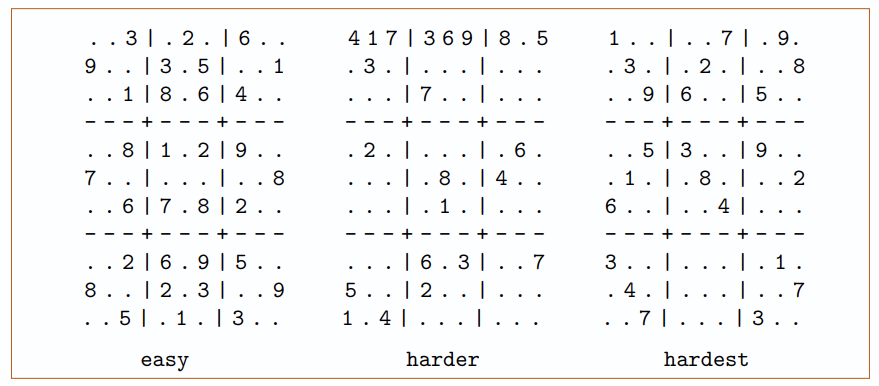

Run Sudoku on each of the algorithms above on the three predefined sudoku puzzles. To do
so, see the comment on line 18 and 36 of sudoku.py.
Answer the following questions.

(a) Which of the algorithms Depth-first graph search, AC-3, Backtracking search and Minconflicts works in a timely manner (say a couple of minutes max) and which doesn’t?
Explain your results in terms of the capabilities of the algorithms and the nature of the
problems.

(b) What effect does configuring the settings for Backtracking search has on the results? Try
the following.
- Open the file aima\csp.py on line 250 where the backtracking search is defined. This
function takes four arguments; csp, select unassigned variable, order domain values
and inference. By setting the last three arguments you can run BT with heuristics.
As it is now, it runs only BT (no heuristics is used).
- For example, to run BT+MRV4
replace **select unassigned variable=first-unassigned-variable** with **select unassigned variable=mrv**.
To run BT+FC replace inference=no inference with inference=forward checking.
To run BT+LCV5
replace order domain values=unordered domain values with
order domain values=lcv.
You can have any combination of them.

Which of these settings BT, BT+FC, BT+MRV or BT+FC+MRV work best for sudoku?


###Answers:
####a)
- Depth_first_graph search (Slow, reliable)
  - easy - 0:01:16.600386 - fails a lot of times
  - harder - still running
  - hardest - 0:07:17.820406

- backtracking_search  (Slightly slower, reliable)
  - easy- Max pc - 0:00:16.156020
  - harder- Max pc - still running
  - hardest - Max pc - 0:07:27.431392

- AC3 (Very fast unreliable)
  - easy - 0:00:00.030979
  - harder - Failed domains
  - hardest - Failed domains

- Min-conflicts (Fast unreliable)
  - easy - 0:00:55.538606
  - harder - Failed domains
  - hardest - Failed domains

####b) - (Hardest only)
- Forward checking(FC) --> 0:00:00.220398
- MRV --> still running
- FC + MRV --> 0:00:00.062955
- FC + MRV + LCV --> 0:00:00.019210

## Soduko Code

In [13]:
#pip install aima

In [14]:
"""  TASK 1/LAB2  TNM096
     Run the various CSP solvers on selected Sudoku puzzles   """

from time import time
from datetime import timedelta
#from aima.csp import Sudoku, AC3, backtracking_search, mrv, forward_checking, min_conflicts
#from aima.search import depth_first_graph_search

In [15]:
def secondsToStr(t):
    return str(timedelta(seconds=t))
def now():
    return secondsToStr(time())

print("\nSetting up the puzzle at\n     "+now()[12:20])
print("\nStart:")


# 1. Set up the puzzle; select ONLY one of the following problem specifications

# ------ solved
#puzzle = Sudoku('483921657967345821251876493548132976729564138136798245372689514814253769695417382')  #solved

# ------ easy
puzzle = Sudoku('..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..')

# ------ harder
#puzzle = Sudoku('4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......')

# ------ hardest
#puzzle = Sudoku('1....7.9..3..2...8..96..5....53..9...1..8...26....4...3......1..4......7..7...3..')

puzzle.display(puzzle.infer_assignment())
start = time()

# 2. Solve the puzzle; select ONLY one of the following algorithms

#depth_first_graph_search(puzzle)
#a = backtracking_search(puzzle) # skriver ut saker utan a =
#AC3(puzzle)
min_conflicts(puzzle)


Setting up the puzzle at
     12:03:49

Start:
. . 3 | . 2 . | 6 . .
9 . . | 3 . 5 | . . 1
. . 1 | 8 . 6 | 4 . .
------+-------+------
. . 8 | 1 . 2 | 9 . .
7 . . | . . . | . . 8
. . 6 | 7 . 8 | 2 . .
------+-------+------
. . 2 | 6 . 9 | 5 . .
8 . . | 2 . 3 | . . 9
. . 5 | . 1 . | 3 . .


In [16]:
# 3. Print the results
print("")
if puzzle.goal_test(puzzle.infer_assignment()):
    print("Solution:")
    puzzle.display(puzzle.infer_assignment())
else:
    print("Failed - domains: ")
    #print str(puzzle.curr_domains)
    #print(puzzle.curr_domains)


Failed - domains: 


In [17]:
# 4. Print elapsed time
end = time()
elapsed = end-start
print("\nElapsed time ",  secondsToStr(elapsed)[0:15])


Elapsed time  0:00:43.121586


# Task 2 - NQueens

The implementation for the NQueens problem provided in this lab includes calls to the algorithms Depth-first graph search, AC-3, Backtracking search, and Min-conflicts, and allows you
to specify n.
The file queensS.py contains the implementation of depth-first tree search algorithm, and queensCSP.py contains the implementation of AC3, Backtracking search and Min-conflicts algorithms.
Run each of the algorithms with various values for n. Answer the following questions.

(a) How large can n be for each of the algorithms? Why?

(b) What Backtracking search settings work the best? Why?

(c) How many steps does Min-Conflicts require to do its work?

(d) Compare the nature of the heuristics deployed in traditional state-based search and constraint-based problem solving.

###Answers:
####a)
- Depth_first_graph search
  - n = 4 --> 0s
  - n = 10 --> 0s
  - n = 15 --> 0s
  - n = 20 --> 0:00:07.970854
  - n = 22 --> 0:01:18.689229

- backtracking_search  
  - Raw - backtracking
    - n = 10 --> 0s
    - n = 20 --> ~1s
    - n = 23 --> ~1s
    - n = 25 --> ~1s
    - n = 28 --> ~30s

  - full backtracking -  n = 225 - 0:00:03.857377
  - mrv backtracing - n = max 150 - 0:00:02.848592, kinda random becomes unreliable
  - FC backtracking - n = 29 - 0:00:07.033134

- AC3
 - Won't run for any N

- Min-conflicts
  - n = 10 --> 0s
  - n = 15 --> 0s
  - n = 20 --> 0s
  - n = 30 --> 0s
  - n = 100 --> 0s
  - n = 150 --> 0.01s
  - n = 300 --> 0.06s
  - n = 1000 --> 0.6s
  - n = 2000 --> 2.33s
  - n = 3000 --> 5.33s
  - n = 4000 --> 9.25s
  - n = 6000 --> 21.39s
  - n = 10.000 --> 0:01:00.821877
  
####b)
Full backtracking, i.e. FC+MRV, had best performance.
2nd MRV
3rd FC

####c)
 n = 20 --> 15 steps
 n = 1000 --> 52 steps / 53 steps / 44 steps
 n = 10000 --> 42 steps / 38 steps
####d)

Min-Conflicts is better for queens since it takes small, local, steps to improve the results. For soduko it does not work that well since we will have many local minima which could lead to dead ends

Backtracking is better for soduko since it can handle the local minima better, but does not work as well for queens since it might miss quick and easy solutions.

## queensS

In [18]:
"""  TASK2/LAB2    TNM096
     Solve the nQueens problem by using depth-first search            """


from time import time
from datetime import timedelta
#from aima.search import depth_first_tree_search, NQueensProblem, Problem

def secondsToStr(t):
    return str(timedelta(seconds=t))

def now():
    return secondsToStr(time())


# 1. Set up the problem and set the starting time
n = 10 #40

print("\nStarting at at  "+now()[12:20])
print("problem with n =",n)
start = time()

# 2. Solve the NQueens problem with depth-first search
solution = depth_first_tree_search(NQueensProblem(n))
sol = str(solution)
print("Solution: ", sol[5:len(sol)-1])


# 3. Print time elapsed
end = time()
elapsed = end-start
print("\nElapsed time ",  secondsToStr(elapsed)[0:15])



Starting at at  12:04:32
problem with n = 10
Solution:   [9, 7, 4, 2, 0, 5, 1, 8, 6, 3]

Elapsed time  0:00:00.001282


## queensCSP

In [19]:
"""  TASK2/LAB2    TNM096
     Run the various CSP solvers on the nQueens problem            """

from time import time
from datetime import timedelta
#from aima.csp import backtracking_search, NQueensCSP, min_conflicts, mrv, \
#   forward_checking, AC3


def secondsToStr(t):
    return str(timedelta(seconds=t))

def now():
    return secondsToStr(time())


# 1. Set up the problem and starting time
n = 5

print("\nStarting at at  "+now()[12:20])
print("problem with n =",n)
start = time()

problem = NQueensCSP(n)

# 2. Solve the problem
solution = backtracking_search(problem)
#solution = AC3(problem);
#solution = min_conflicts(problem)


# 3. Print the results

# Handle AC3 solutions (boolean values) first, they behave differently.
if type(solution) is bool:
    if solution and problem.goal_test(problem.infer_assignment()):
        print("AC3 Solution:")
        print(problem.curr_domains)
    else:
        print("AC3 Failure")
        print(problem.curr_domains)
# Handle other solutions next
elif problem.goal_test(solution):
    print("Solution:", solution)
else:
    print("Failed - domains: " + str(problem.curr_domains))
    #problem.display(problem.infer_assignment())


# 4. Print elapsed time

end = time()
elapsed = end-start
print("\nElapsed time ",  secondsToStr(elapsed)[0:15])


Starting at at  12:04:32
problem with n = 5
Solution: {2: 0, 0: 1, 3: 2, 4: 4, 1: 3}

Elapsed time  0:00:00


# Task 3 - Classroom Scheduling as a CSP
One of the succesfull application of Min-Conflicts algorithm is to solve scheduling problems6.
This task is about to write an implementation of Min-Conflicts to solve the problem below.
You can use any programming language.

Classroom Scheduling

You are in charge of assigning classes to classrooms and times. You have to schedule three
classrooms: TP51, SP34 and K3. Classes start on the hour. You can only assign classes to the
hours of:

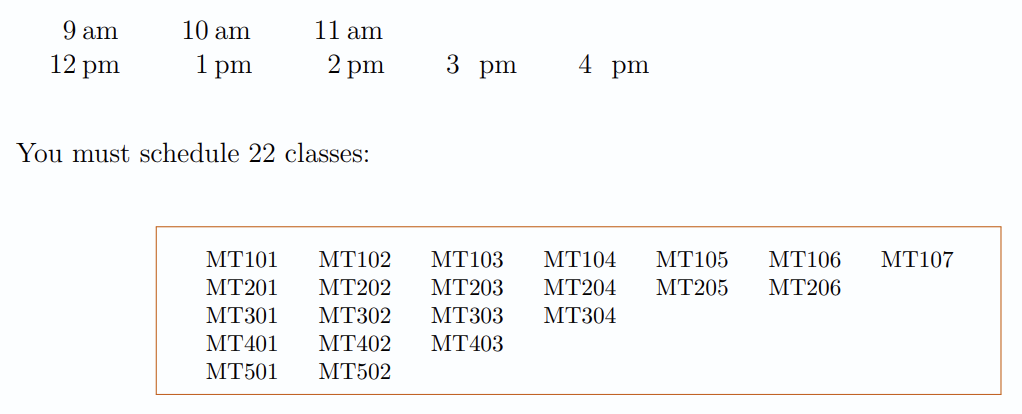

Your schedule must not violate any of the following requirements:
1. Two classes cannot meet in the same classroom at the same time.
2. Classes whose first digit are the same (like MT102 and MT107) cannot be scheduled at the same time because students might take them both in one semester. There is one exception to this rule; MT501 and MT502 can be scheduled at the same time since students can only take one of them.

Write a display function that prints the schedule you have computed.

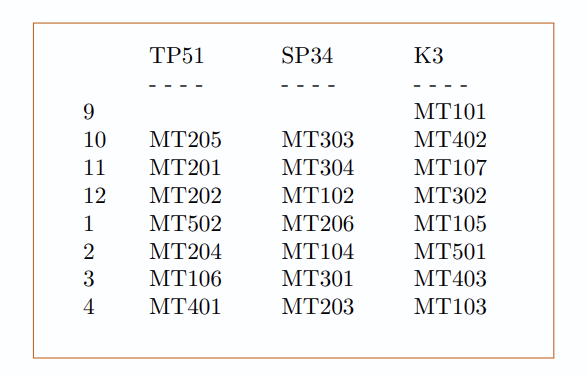

In [39]:
import random
def genRandomTableOfClasses():
  classes = [101, 102, 103, 104, 105, 106, 107, 201, 202, 203, 204, 205, 206, 301, 302, 303, 304, 401, 402, 403, 501, 502]
  TP51 = [None] * 8
  SP34 = [None] * 8
  K3 = [None] * 8

  Table = [TP51, SP34, K3]

  for aClass in classes:
    added = False
    while not added:
      room = random.randint(0,2)
      time = random.randint(0,7)
      if Table[room][time] == None:
        Table[room][time] = aClass
        added = False
        break

  return Table

def getConflicts(Table):
  conflictTable = [[False] * 8, [False] * 8, [False] * 8]
  for time in range(8):
    for room1 in range(3):
      for room2 in range(3):
        if not room1 == room2:
          class1 = Table[room1][time]
          class2 = Table[room2][time]
          if not (class1 == None or class2 == None):
            year1 = math.floor(class1 / 100)
            year2 = math.floor(class2 / 100)
            if year1 == year2 and year1 != 5:
              conflictTable[room1][time] = True
  return conflictTable

def countConflicts(conflictTable):
  conflicts = 0
  for room in range(3):
    for time in range(8):
      if conflictTable[room][time] == True:
        conflicts += 1
  return conflicts

def minimizeConflicts(Table, rRoom, rTime):
  #swapTable = [[25] * 8, [25] * 8, [25] * 8]
  minValue = 25
  wantedRoom = -1
  wantedTime = -1
  for room in range(3):
    for time in range(8):
      # compare with all other roomes
      if not (room == rRoom and time == rTime):
        # swap, store value, swap back
        Table[room][time], Table[rRoom][rTime] = Table[rRoom][rTime], Table[room][time]
        #swapTable[room][time] = countConflicts(getConflicts(Table))
        if minValue > countConflicts(getConflicts(Table)):
          wantedRoom = room
          wantedTime = time
          minValue = countConflicts(getConflicts(Table))
        Table[room][time], Table[rRoom][rTime] = Table[rRoom][rTime], Table[room][time]
  return (wantedRoom, wantedTime)

def minConflictsClasses(Table):
  maxSteps = 100000
  # https://en.wikipedia.org/wiki/Min-conflicts_algorithm
  for step in range(maxSteps):
    conflictTable = getConflicts(Table)
    numConflicts = countConflicts(conflictTable)
    if numConflicts == 0:
      return (Table, 0)

    # set var ← a randomly chosen variable from the set of conflicted variables CONFLICTED[csp]
    rRoom = random.randint(0,2)
    rTime = random.randint(0,7)
    while(conflictTable[rRoom][rTime] == False):
      rRoom = random.randint(0,2)
      rTime = random.randint(0,7)

    # var is the same as conflictTable[rRoom][rTime]
    # set value ← the value v for var that minimizes CONFLICTS(var,v,current_state,csp)
    wantedRoom, wantedTime = minimizeConflicts(Table, rRoom, rTime)
    # we make the swap,
    Table[wantedRoom][wantedTime], Table[rRoom][rTime] = Table[rRoom][rTime], Table[wantedRoom][wantedTime]

  return (Table, numConflicts)

In [40]:
import time

In [41]:
start = time.time()
result = minConflictsClasses(genRandomTableOfClasses())
end = time.time()

In [42]:
print(end - start)

0.0004956722259521484


In [43]:
result

([[None, 303, 402, 105, 102, 301, 107, 502],
  [103, 401, 201, 205, 202, 204, 501, 403],
  [206, 101, 106, 304, None, 104, 203, 302]],
 0)

#Task 4 - Classroom Scheduling with Preferences

Solve the scheduling problem of Task 3 again but with the addition of these preferences:
* Prefer schedules that do not schedule classes at 9 am, 12 pm and 4 pm.
* Prefer schedules where MT501 and MT502 are scheduled at 1 pm or 2 pm

Discussion

In my solution I tried to integrate scheduling and preferences directly in one algorithm. It
seems to be a difficult problem and my solution does not work so well either (inefficient and mediocre schedules).

Tip To accomplish this task, do not modify your implementation of Min-Conflicts
implemented in Task 3. Do the following.
1. Write another function that calls Min-Conflicts repeatedly.
2. For each solution found count the number of preferences that are not satisfied. Save the
solution with the smallest count of unsatisfied preferences.
3. Search for the best solution by repeatedly calling Min-Conflicts for a max number of
times.
4. At the end return the solution found with the smallest count of unsatisfied preferences.


In [44]:
def countPreferencesNotSatisfied(Table):
  prefNotSatisfied = 0
  for room in range(3):
    for time in range(8):
      #print(time)
      # these times are bad
      # 9 -> index 0; 12 pm -> index 3; 4 pm index 7
      if time == 0 or time == 3 or time == 7:
        prefNotSatisfied += 1
      class1 = Table[room][time]
      if not class1 == None:
        year = math.floor(class1 / 100)
        if year == 5:
          # 1 pm -> index 4, 2pm -> index 5
          if not (time == 4 or time == 5):
            prefNotSatisfied += 1
  return prefNotSatisfied

In [45]:
import random
def repeatMinConflicts():
  maxSteps = 100000
  prefNotSatisfied = 25
  savedTable= []
  # https://en.wikipedia.org/wiki/Min-conflicts_algorithm
  for step in range(maxSteps):
    randomTable = genRandomTableOfClasses()

    result2 = minConflictsClasses(randomTable) # loops around 100000 times
    #table2 = getTable(result2)
    if not result2[1] == 0:
      continue

    table2 = result2[0]

    numPreferences2 = countPreferencesNotSatisfied(table2)
    if numPreferences2 < prefNotSatisfied:
      savedTable = table2
      prefNotSatisfied = numPreferences2
      #print(savedTable)
    if prefNotSatisfied == 0:
      break
  return (savedTable, prefNotSatisfied)

In [46]:
start = time.time()
resultRepeat = repeatMinConflicts()
end = time.time()

In [47]:
print(end - start)

106.19894862174988


In [48]:
resultRepeat[1]

9

In [50]:
resultRepeat[0]


# Pretty print
def prettyPrintTable(table):
  stringarray = ["TP51", "SP34", "K3"]
  for room in range(3):
    print(stringarray[room])
    for time in range(8):
      if table[room][time] == None:
        print("None")
      else:
        print(table[room][time])
    print("\n")
  return None
prettyPrintTable(resultRepeat[0])

TP51
401
104
302
403
203
204
301
303


SP34
102
202
206
105
502
304
None
103


K3
201
None
106
205
101
501
107
402


